# Bank Loan EDA and logistic regression

## Requirements
1. Python installation - 3.6.8
2. Pandas
3. Matplotlib 3.1.0 --> 3.1.1 has broken heat maps where it does not annotate problem
4. SKLearn
4. Statsmodel
5. Numpy
6. Seaborn

## Import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
%matplotlib inline

## Question 1 - Read columns

In [2]:
cData = pd.read_csv("Bank_Personal_Loan_Modelling.csv")
print(cData.shape)
cData.head()

(5000, 14)


,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
cData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


From the above, it appears
1. Data is clean and has no null values
2. All data is numeric. Some of the columns are categorical though which might need data type conversion
3. Number of rows is 5000 and number of colums is 14
4. Education column has values that represent the type of education. This might need One Hot encoding.

### Convert datatypes

In [4]:
#Since ID is same as pandas indexes, lets set it as such
cData.set_index('ID', inplace=True)

In [5]:
#Convert zip code to categorical datatype
cData[['ZIP Code']] = cData[['ZIP Code']].astype('category')

In [6]:
if cData.isnull().sum().sum() == 0: print("Nothing to cleanup") 

Nothing to cleanup


In [7]:
def func(row):
    if row.Education == 1:
        return 'Undergrad'
    elif row.Education == 2:
        return 'Graduate'
    else:
        return 'Professional'
    
cData['Education'] = cData.apply(func, axis=1)
cData[['Education']] = cData[['Education']].astype('category')

In [8]:
cData[['CD Account']].nunique()

CD Account    2
dtype: int64

In [9]:
cData[['Securities Account']] = cData[['Securities Account']].astype('category')
cData[['CD Account']] = cData[['CD Account']].astype('category')
cData[['Online']] = cData[['Online']].astype('category')
cData[['CreditCard']] = cData[['CreditCard']].astype('category')
cData[['Personal Loan']] = cData[['Personal Loan']].astype('category')

In [10]:
cData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null category
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null category
Mortgage              5000 non-null int64
Personal Loan         5000 non-null category
Securities Account    5000 non-null category
CD Account            5000 non-null category
Online                5000 non-null category
CreditCard            5000 non-null category
dtypes: category(7), float64(1), int64(5)
memory usage: 336.7 KB


From the above calcuations
1. We set the index column correctly as this data as column makes no difference to actual model building process
2. We changed the column data types which we can use to plot graphs
3. Converted the numeric values of Education colum properly which will be used for plotting graphs and one hot encoding

## Question 2 - Column by column analysis

In [11]:
def dist_box_plots(data, attribs):
    fig,ax = plt.subplots(figsize=(len(attribs)*3, len(attribs)*3), ncols=2, nrows=len(attribs))
    i = 0
    for a in attribs:
        dist_ax = sns.distplot(data[[a]], ax=ax[i][0])
        dist_ax.set(xlabel="", ylabel=str(a))
        sns.boxplot(x=data[[a]], data=data[[a]], ax=ax[i][1])
        i += 1

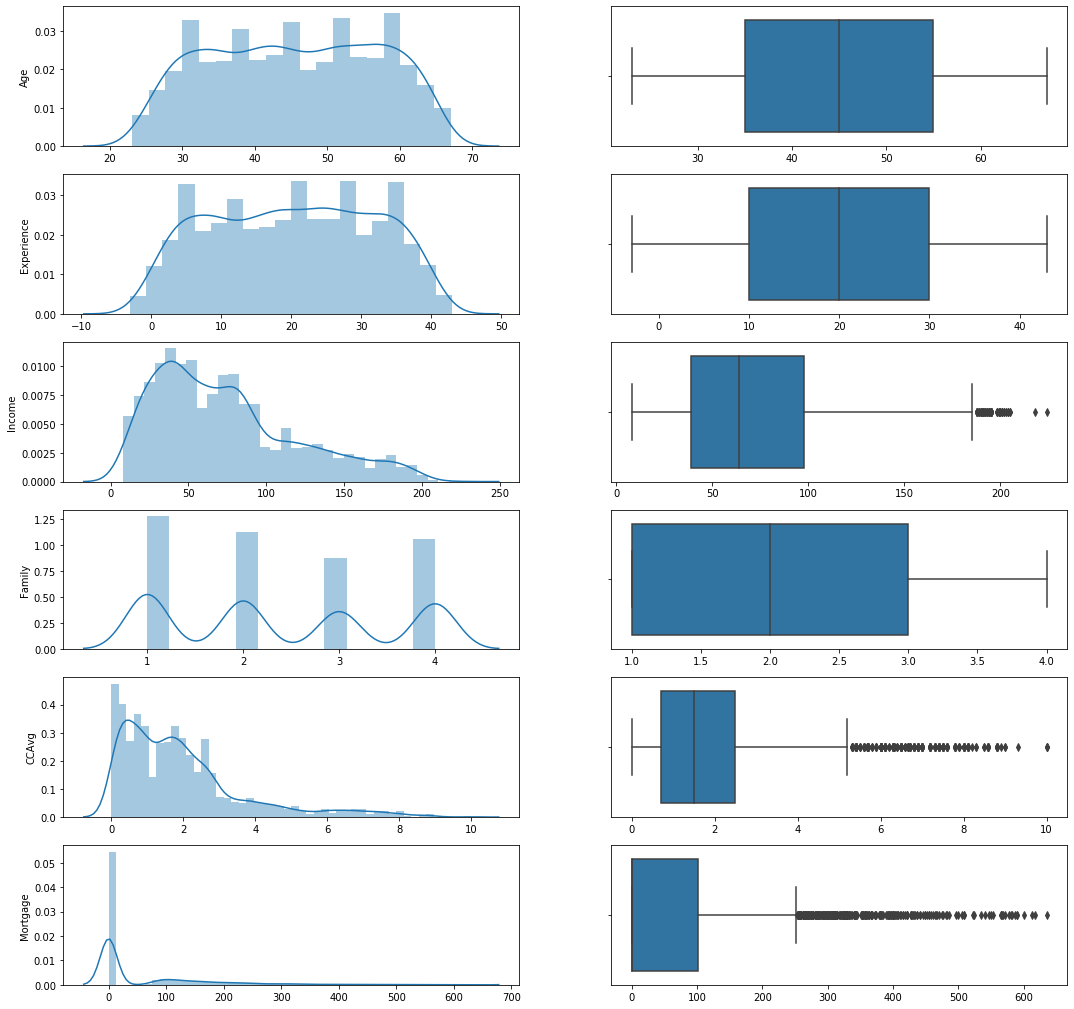

In [12]:
isColumnNumeric = cData.dtypes.apply(lambda x: (x == 'int64' or x == 'float64'))
dist_box_plots(cData, isColumnNumeric[isColumnNumeric].index)

From the above:
1. Age is evenly distributed around the mean value value of 45
2. Experience is evenly distributed around the mean value of 20
3. Income data is left skewed with a few outliers
4. Family members are 1, 2, 4 and 3 in descending order
5. Average Credit card spend is left skewed where most people spend less than 2.5k
6. Mortgate data is highly left skewed

In [13]:
def count_plots(data, attribs):
    fig,ax = plt.subplots(figsize=(10, len(attribs)*8), ncols=1, nrows=len(attribs))
    i = 0
    for a in attribs:
        count_ax = sns.countplot(data[a], ax=ax[i])
        i += 1

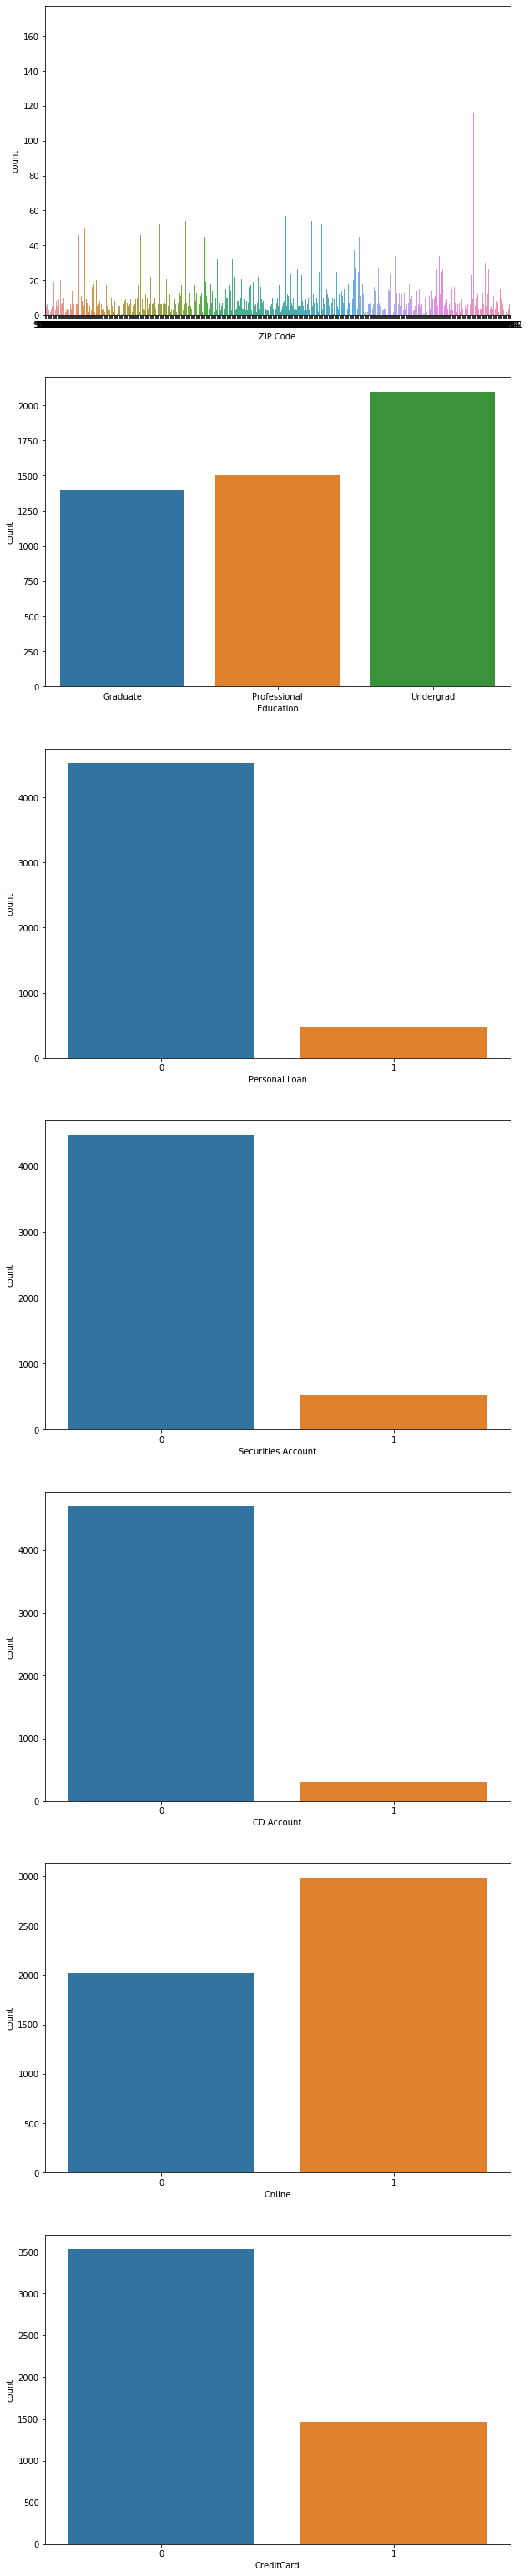

In [14]:
isCategoryColumn = cData.dtypes.apply(lambda x: not (x == 'int64' or x == 'float64'))
count_plots(cData, isCategoryColumn[isCategoryColumn].index)

In [15]:
isCategoryColumn[isCategoryColumn].index

Index(['ZIP Code', 'Education', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

From the above:
1. Data contains maximum undergrades with a value of 2k approx while Professional is around 1.5k and graduates 1.4k
2. Only 480 of 5k people have got personal loans
3. Only 522 of 5k people have got securities account
4. Only 300 of 5k people have got Certificate of deposit account 
5. Around 2k of 5K people use online banking profile
6. Around 1.5k of 5K people have credit card issused by universal bank

## Question 3 - Target column distribution

In [16]:
target_variations = {}
for x in isCategoryColumn[isCategoryColumn].index :
    if x == 'Personal Loan' : continue
    target_variations[x] = cData[cData['Personal Loan'] == 1][cData[x] == 1]['Personal Loan'].shape[0]

/home/shrikant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [17]:
target_variations

{'ZIP Code': 0,
 'Education': 0,
 'Securities Account': 60,
 'CD Account': 140,
 'Online': 291,
 'CreditCard': 143}

Above data suggests that 
1. Accepting personal loan in the campain does not depend on ZIP Code and Education

In [18]:
numeric_distribution = cData[isColumnNumeric[isColumnNumeric].index]
numeric_distribution = pd.concat([numeric_distribution, cData['Personal Loan']], axis=1)
numeric_distribution.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal Loan
ID,,,,,,,
1,25,1,49,4,1.6,0,0
2,45,19,34,3,1.5,0,0
3,39,15,11,1,1.0,0,0
4,35,9,100,1,2.7,0,0
5,35,8,45,4,1.0,0,0


In [19]:
def plot_numberic_against_personal_loan(column) :
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.distplot(numeric_distribution[numeric_distribution['Personal Loan'] == 0][column], kde=False, color='b')
    sns.distplot(numeric_distribution[numeric_distribution['Personal Loan'] == 1][column], kde=False, color='g')

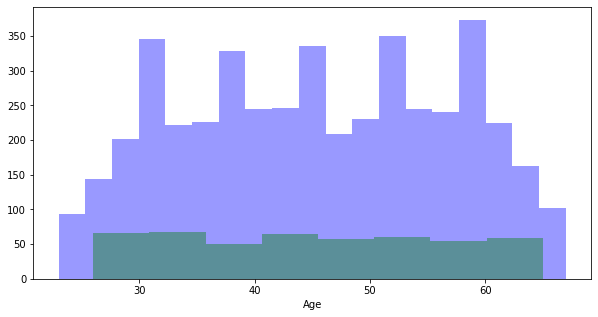

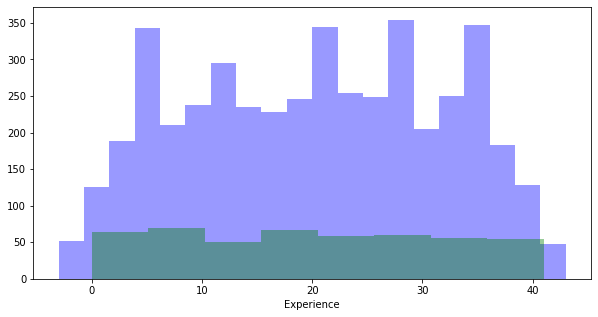

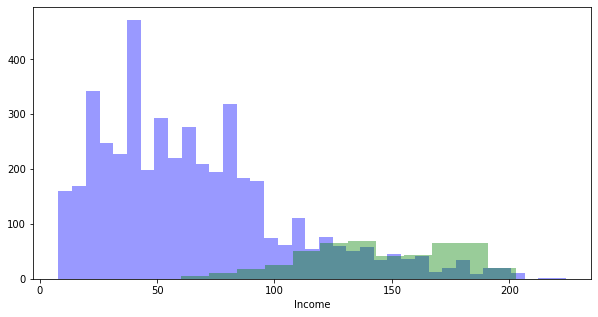

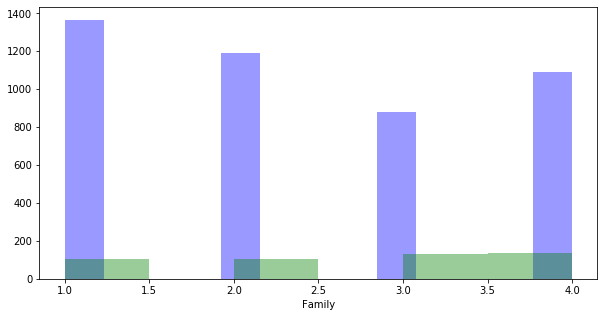

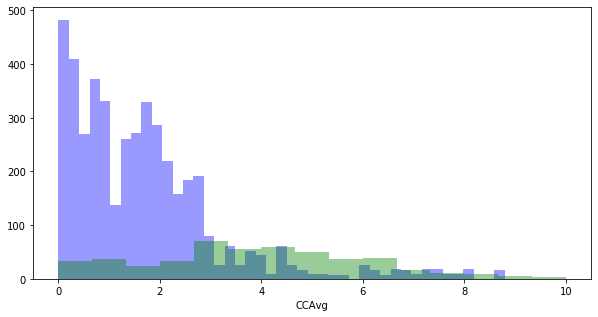

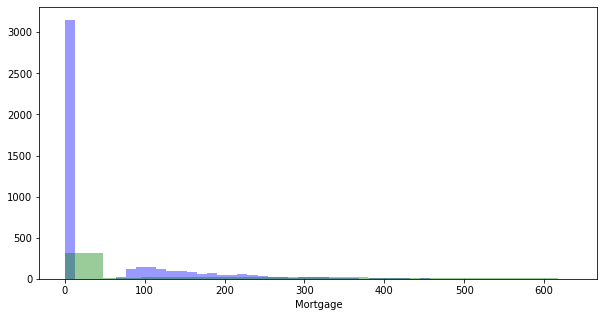

In [20]:
for x in isColumnNumeric[isColumnNumeric].index:
    plot_numberic_against_personal_loan(x)

Above graphs suggest
1. Accepting or rejecting of Personal loan is evenly distributed against Age, Experience and Family size
2. People with high income have a better chance of accepting a personal loan
3. People with less average credit card spend are less likely of accepting a personal loan
4. People with less mortgage have a high chance of accepting the personal loan

## One hot encoding

In [21]:
cData = pd.read_csv("Bank_Personal_Loan_Modelling.csv")
cData.set_index('ID', inplace=True)
cData.drop('ZIP Code', inplace=True, axis=1) 

In [22]:
cData = pd.get_dummies(cData, prefix="Education_", columns=['Education'])

## Question 4 - Splitting the data

In [23]:
x = cData.drop("Personal Loan", axis=1)
y = cData[['Personal Loan']]

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

In [25]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3500, 13)
(3500, 1)
(1500, 13)
(1500, 1)


## Question 5 - Model building

### Using sklearn

In [26]:
model = LogisticRegression(solver="liblinear")
model.fit(x_train, y_train)
y_predict = model.predict(x_test)

/home/shrikant/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
model_score = model.score(x_test, y_test)
print(model_score)

0.9573333333333334


## Question 6 - Confusion matrix

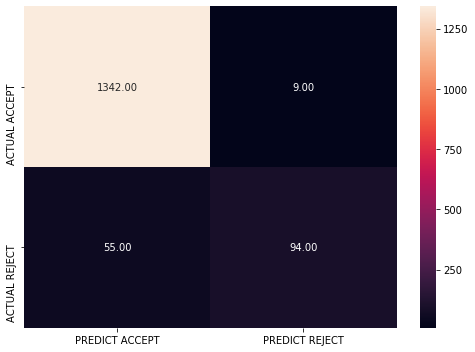

In [28]:
cm = sklearn.metrics.confusion_matrix(y_test, y_predict, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["YES","NO"]],
                  columns = [i for i in ["PREDICT YES","PREDICT NO"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='.2f', 
           xticklabels = ["PREDICT ACCEPT", "PREDICT REJECT"],
           yticklabels = ["ACTUAL ACCEPT", "ACTUAL REJECT"])
plt.tight_layout()

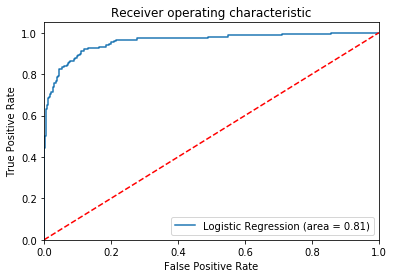

In [29]:
logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [30]:
### Acuracy scores
print(classification_report(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1351
           1       0.91      0.63      0.75       149

    accuracy                           0.96      1500
   macro avg       0.94      0.81      0.86      1500
weighted avg       0.96      0.96      0.95      1500



### Using statsmodel logit function

In [31]:
logit = sm.Logit( y_train, sm.add_constant( x_train ) )
lg = logit.fit()
lg.summary2()

Optimization terminated successfully.
         Current function value: 0.114079
         Iterations 9


/home/shrikant/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/shrikant/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home/shrikant/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/shrikant/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/shrikant/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.636      
Dependent Variable: Personal Loan    AIC:              824.5501   
Date:               2019-12-13 22:55 BIC:              904.6368   
No. Observations:   3500             Log-Likelihood:   -399.28    
Df Model:           12               LL-Null:          -1095.5    
Df Residuals:       3487             LLR p-value:      6.1376e-291
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     9.0000                                        
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              -7.5499      nan     nan    nan     nan     nan
Age                -0.0231   0.0800 -0.2889 0.7726 -0.1798  0.1336
Experience          0.0283   0.0796  0.3561 0.7218 -0.1276  0.1843
Income              0.0588   0.0036 16.4489 0.0000  0.0518  0.0658
Family              0.6490   0.0959  6.7656 0.0000  0.4610  0.8370
CCAvg               0.2109   0.0538  3.9221 0.0001  0.1055  0.3164
Mortgage            0.0010   0.0007  1.4063 0.1596 -0.0004  0.0024
Securities Account -1.1627   0.3995 -2.9104 0.0036 -1.9456 -0.3797
CD Account          3.8362   0.4251  9.0232 0.0000  3.0029  4.6694
Online             -0.6622   0.2000 -3.3113 0.0009 -1.0542 -0.2703
CreditCard         -1.0679   0.2600 -4.1080 0.0000 -1.5774 -0.5584
Education__1       -5.1695      nan     nan    nan     nan     nan
Education__2       -1.2611      nan     nan    nan     nan     nan
Education__3       -1.1192      nan     nan    nan     nan     nan
==================================================================

"""

Above summary provides different scores for Logit model and coefficiets for the equation and other information

In [32]:
threshold_to_prediction = {}

def predict(threshold) :
    y_pred_df = pd.DataFrame( { 'actual': y_test['Personal Loan'],
                               "predicted_probability": lg.predict( sm.add_constant( x_test ) ) } )
    y_pred_df['predication'] = y_pred_df.predicted_probability.map( lambda x: 1 if x > threshold else 0)
    correctly_predicted = y_pred_df[y_pred_df.predication == y_pred_df.actual].shape[0]
    incorrectly_predicted = y_pred_df[y_pred_df.predication != y_pred_df.actual].shape[0]
    
    percent = round((correctly_predicted/(correctly_predicted+incorrectly_predicted)) * 100, 2)
    
    threshold_to_prediction[round(threshold, 1)] = percent

In [33]:
for x in np.arange(0.1, 1.1, 0.1) :
    predict(x)

threshold_to_prediction

{0.1: 90.27,
 0.2: 94.33,
 0.3: 95.13,
 0.4: 95.87,
 0.5: 95.8,
 0.6: 95.53,
 0.7: 94.73,
 0.8: 94.27,
 0.9: 93.73,
 1.0: 90.07}

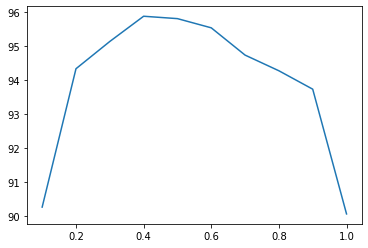

In [34]:
plt.plot(list(threshold_to_prediction.keys()), list(threshold_to_prediction.values()))

From the above:
1. Above plot shows how changing threshold values affects prediction
2. Selecting the threshold value around 0.5 gives best prediction scores

In [35]:
#Considering the threshold at 0.5 
y_pred_df = pd.DataFrame( { 'actual': y_test['Personal Loan'],
                               "predicted_probability": lg.predict( sm.add_constant( x_test ) ) } )
y_pred_df['predication'] = y_pred_df.predicted_probability.map( lambda x: 1 if x > 0.5 else 0)

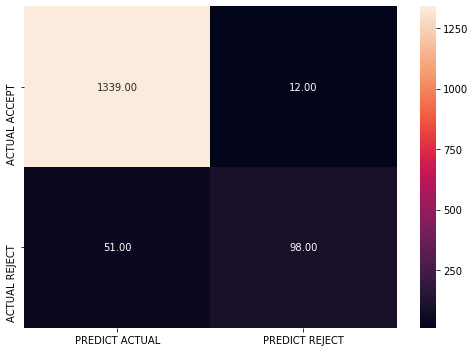

In [36]:
cm = sklearn.metrics.confusion_matrix(y_pred_df.actual, y_pred_df.predication, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = [i for i in ["ACTUAL ACCEPT","ACTUAL REJECT"]],
                  columns = [i for i in ["PREDICT ACCEPT","PREDICT REJECT"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True, fmt='.2f', 
           xticklabels = ["PREDICT ACTUAL", "PREDICT REJECT"],
           yticklabels = ["ACTUAL ACCEPT", "ACTUAL REJECT"])
plt.tight_layout()

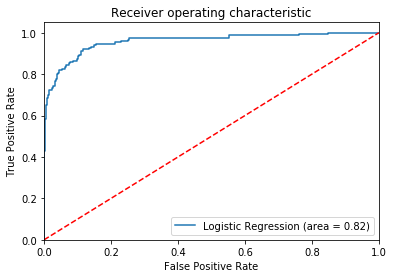

In [37]:
logit_roc_auc = roc_auc_score(y_pred_df.actual, y_pred_df.predication)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_df.predicted_probability)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [38]:
### Acuracy scores
print(classification_report(y_pred_df.actual, y_pred_df.predication))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1351
           1       0.89      0.66      0.76       149

    accuracy                           0.96      1500
   macro avg       0.93      0.82      0.87      1500
weighted avg       0.96      0.96      0.96      1500



## Question 7 - Reasoning behind models selection

In the above example, we used Logit function from statsmodel(with threshold = 0.5) and Logit function from sklearn and found that both predict similar results

Considering for example, if it is okay for business to predict a customer accepted the personal loan as part of the campain but our model predicts that the customer rejected the loan while it is not acceptable the other way around.
This means we need to maximize true positive from all the positive predications or we need to maximize Precision values

In [39]:
def maximize_precision(threshold_diff):
    max_val = 0
    curr_th = 0
    for y in np.arange(0.1, 1+threshold_diff, threshold_diff) :
        curr = sklearn.metrics.precision_score(y_pred_df.actual, 
                             lg.predict(sm.add_constant(x_test)).map(lambda x: 1 if x>y else 0))
        max_val = max(max_val, curr)
        if max_val == curr:
            curr_th = y
    print("Max precision is {} at threshold {}".format(max_val, curr_th))
    

maximize_precision(0.25)

Max precision is 0.9836065573770492 at threshold 0.8499999999999999


/home/shrikant/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/home/shrikant/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


So the correct threshold for the given scenario is 0.85

## _______END_________